In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import os

In [3]:
# Grab info about images
labels_df = pd.read_csv('/content/drive/My Drive/CS 4641/preprocessed data/df_full.csv')
# labels_df now maps an image to its label
labels_df = labels_df[['Waveform Plot Filename', 'Diagnosis']]

In [4]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,        # Normalization
    # The rest of this stuff is what are called Augmentations.
    rotation_range = 10,    # Random rotation between 0 and 10 degrees
    width_shift_range=0.1,  # Shift the image width by a max of 10%
    height_shift_range=0.1, # Shift the image height by a max of 10%
    shear_range=0.1,        # Shear transformation
    zoom_range=0.1,         # Zoom in on the image
    horizontal_flip=True,   # Allow horizontal flipping
    fill_mode='nearest',    # Fill in any pixels lost during transformation
    # Note, we'll use 80/20 split
    validation_split=0.2
)

# Reformatted to we can map absolute filepaths to label
base_image_directory = "/content/drive/MyDrive/CS 4641/preprocessed data/waveform images"
labels_df['Waveform Plot Filename']=labels_df['Waveform Plot Filename'].str.slice(15)
labels_df['Waveform Plot Filename'] = base_image_directory + labels_df['Waveform Plot Filename']


In [5]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=None,                  # None because we provide absolute paths
    x_col='Waveform Plot Filename',  # Column in dataframe that contains the filenames
    y_col='Diagnosis',               # Column in dataframe that contains the labels
    target_size=(100, 300),          # Resize images while preserving aspect ratio
    color_mode='rgb',                # Since this is technically a color image
    class_mode='categorical',        # For multi-class classification problem
    batch_size=32,                   # Adjust based on GPU capacity
    shuffle=True,                    # Shuffle the data
    subset='training',               # Specify this is training data
    seed=69                          # Seed for reproducibility
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=labels_df,
    x_col='Waveform Plot Filename',
    y_col='Diagnosis',
    target_size=(100, 300),         # Must be the same as target_size in train_generator
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,                  # Same as train_generator or smaller if we want to
    shuffle=True,                   # Usually you shuffle the validation set as well
    subset='validation',            # Specify this is validation data
    seed=69                         # Same seed as above
)

Found 737 validated image filenames belonging to 8 classes.
Found 184 validated image filenames belonging to 8 classes.


In [6]:
# Define the CNN model
model = Sequential()

# Convolutional layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 300, 3))) 
model.add(MaxPooling2D((2, 2)))

# Convolutional layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Convolutional layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten output of the convolutional layers to feed into dense layers
model.add(Flatten())

# Dense layer w dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer w softmax activation for multi-class classification
number_of_classes = labels_df['Diagnosis'].nunique()
model.add(Dense(number_of_classes, activation='softmax'))

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=25,  # Start with a small number of epochs; you can increase this later.
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)
from sklearn.metrics import f1_score
validation_generator.reset()
y_pred = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = validation_generator.classes
f1_macro = f1_score(y_true_classes, y_pred_classes, average='macro')
print(f"F1 Macro Score: {f1_macro}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 298, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 149, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 147, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 35, 128)       0

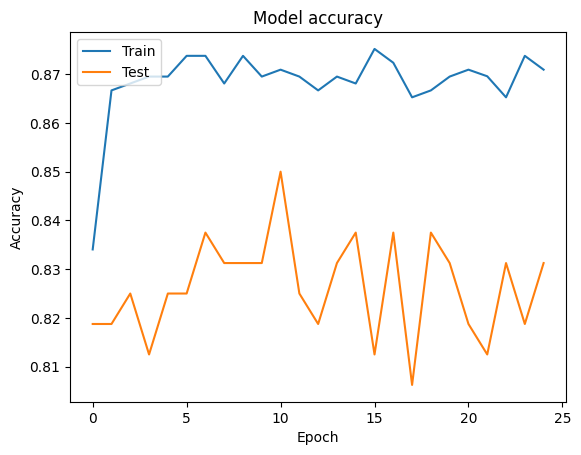

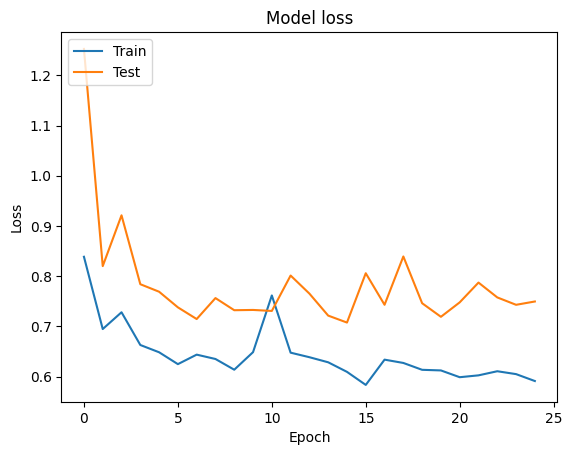

In [8]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()